## Семинар 7: "Методы оптимизации"

ФИО: Какурин Василий Владимирович

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

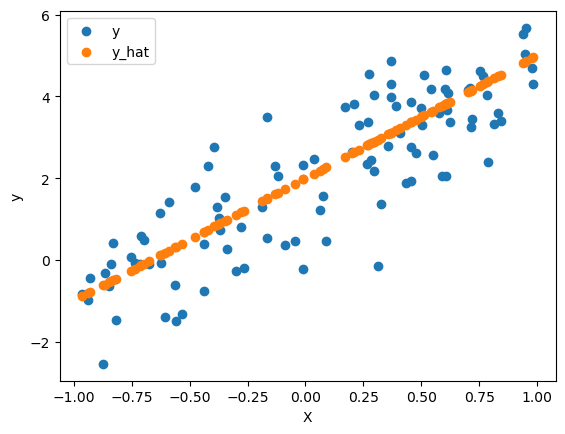

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

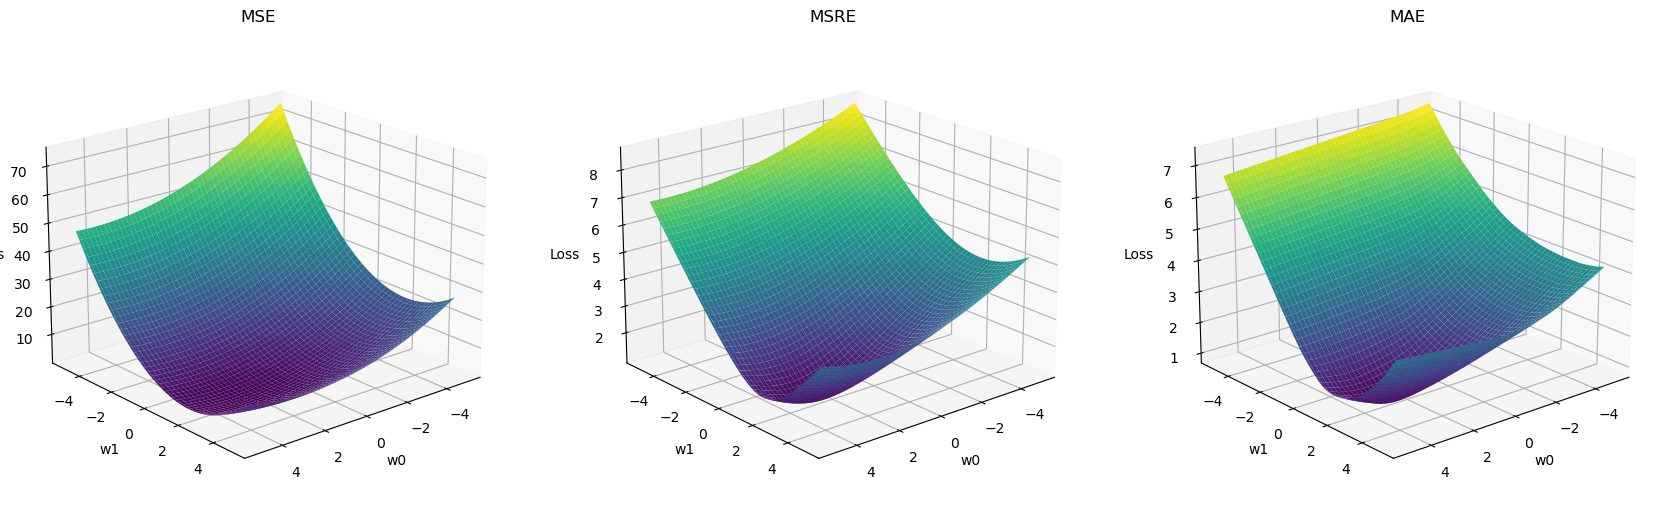

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad
        
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma:float=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = {}
        
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.v[i] = self.gamma * (self.v[i] if i in self.v else 0)\
                       + self.lr * p.grad
                p -= self.v[i]  
        
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma:float=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.v = {}
        
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.v[i] = self.gamma * (self.v[i] if i in self.v else 0)\
                       + self.lr * p.grad
                p -= self.v[i] * (1 + self.gamma)    
        
class AdaGrad(Optimizer):
    def __init__(self, params, lr=1e-2, eps:float=1e-6):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.G = {}
        
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G = (self.G[i] if i in self.G else 0) + torch.square(p.grad)
                p -= self.lr * p.grad / torch.sqrt(self.G[i] + self.eps)   
        
class AdaDelta(Optimizer):
    def __init__(self, params, gamma:float=0.9, eps:float=1e-6):
        super().__init__(params)
        self.gamma = gamma
        self.eps = eps
        self.G = {}
        self.Dtheta = {}
        
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if(i not in self.Dtheta): self.Dtheta[i] = torch.tensor([0], dtype=float, device=p.device)
                if p.grad is None:
                    continue
                    
                if(i not in self.G): self.G[i] = torch.square(p.grad)
                else: self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * torch.square(p.grad)
                
                dx = torch.sqrt(self.Dtheta[i]) / torch.sqrt(self.G[i] + self.eps) * p.grad
                p -= dx
                
                self.Dtheta[i] = self.gamma * self.Dtheta[i] + (1 - self.gamma) * torch.square(dx)
        
class Adam(Optimizer):
    def __init__(self, params, lr:float=1e-2, beta1:float=0.9, beta2:float=0.99, eps:float=1e-6):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        
    def step(self):
        with torch.no_grad():
            for i,p in enumerate(self.params):
                if p.grad is None:
                    continue
                    
                self.m[i] = self.beta1 * (self.m[i] if i in self.m else 0) + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * (self.v[i] if i in self.v else 0) + (1 - self.beta2) * torch.square(p.grad)
                
                p -= self.lr / torch.sqrt(self.v[i] / (1 - self.beta2) + self.eps) * self.m[i] / (1 - self.beta1)

In [9]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {'lr': 1e-1}, start_point=[-20, -20], num_iter=100)

In [10]:
from torch.optim import SGD as TorchSGD, Adagrad as TorchAdaGrad, Adadelta as TorchAdaDelta, Adam as TorchAdam

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [11]:
compare_optimizers(loss_animator, mse,
                   [
                       ('SGD', SGD, {'lr': 1e-2}),
                       ('Momentum', Momentum, {'lr':1e-2, 'gamma':0.9}),
                       ('NAG', NAG, {'lr':1e-2, 'gamma':0.9}),
                       ('AdaGrad', AdaGrad, {'lr':1e-2}),
                       ('AdaDelta', AdaDelta, {'gamma':0.9}),
                       ('Adam', Adam, {'lr':1e-2, 'beta1':0.9, 'beta2':0.99})
                   ], 
                   start_point = [-5, -5], num_iter=100, step_skip=1)

H:\Programs\Anaconda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
H:\Programs\Anaconda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [12]:
compare_optimizers(loss_animator, mse,
                   [
                       ('SGD', TorchSGD, {'lr': 1e-2}),
                       ('Momentum', TorchSGD, {'lr':1e-2, 'momentum':0.9}),
                       ('NAG', TorchSGD, {'lr':1e-2, 'momentum':0.9, 'nesterov':True}),
                       ('AdaGrad', TorchAdaGrad, {'lr':1e-2}),
                       ('AdaDelta', TorchAdaDelta, {'rho':0.9}),
                       ('Adam', TorchAdam, {'lr':1e-2, 'betas':(0.9, 0.99)})
                   ], 
                   start_point = [-5, -5], num_iter=100, step_skip=1)

H:\Programs\Anaconda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
H:\Programs\Anaconda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


В итоге, моя реализация методов получилась довольно похожей на реализацию из pytorch. Несмотря на то, что есть некоторые отличия - например, моя реализация AdaGrad сходится быстрее Adam, а в pytorch наоборот, общая картина остаётся довольно похожей.

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [13]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [14]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32*4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32*4, shuffle=True)

In [15]:
class NN(nn.Module):
    def __init__(self, layers, act):
        super().__init__()
        self.layers=layers
        self.act=act
        self.main = nn.Sequential()
        for l in layers:
            self.main.append(nn.Linear(*l))
            self.main.append(act())
        
    def forward(self, x):
        return self.main(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:",torch.cuda.get_device_name(device.index) if device.type=="cuda" else device.type)

Device: NVIDIA GeForce GTX 1050


In [16]:
def train(net, optimizer, criterion, epochs):
    losses = []
    test_losses = []

    tq = tqdm(range(epochs))
    for epoch in tq:
        net.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            x      = data[0].to(device, non_blocking=True).reshape(-1, 28*28)
            y_true = data[1].to(device, non_blocking=True)

            y_pred = net(x)
            # y_pred = y_pred.view((y_pred.shape[0], -1, 2))
            loss = criterion(y_pred, y_true)
            loss.backward()

            optimizer.step()

            losses.append(loss.item())

            tq.set_postfix({"state":"train", "pos_loss":loss.item(), "mean_loss":np.mean(losses[-100:]), 
                            "mean_test_loss":(np.mean(test_losses[-5:]) if len(test_losses) else "nan")})

        net.eval()
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                x      = data[0].to(device, non_blocking=True).reshape(-1, 28*28)
                y_true = data[1].to(device, non_blocking=True)

                y_pred = net(x)
                loss = criterion(y_pred, y_true)

                test_losses.append(loss.item())

                tq.set_postfix({"state":"test", "pos_loss":loss.item(), "mean_loss":np.mean(losses[-100:]), 
                                "mean_test_loss":(np.mean(test_losses[-5:]) if len(test_losses) else "nan")})
        
    return losses, test_losses

In [20]:
lr=1e-2
optimizers = [('SGD', SGD, {'lr': 1e-2}),
              ('Momentum', Momentum, {'lr':1e-2, 'gamma':0.9}),
              ('NAG', NAG, {'lr':1e-2, 'gamma':0.9}),
              ('AdaGrad', AdaGrad, {'lr':1e-2}),
              ('AdaDelta', AdaDelta, {'gamma':0.9}),
              ('Adam', Adam, {'lr':1e-2, 'beta1':0.9, 'beta2':0.99})]
losses = {} 
for name, opt, kwargs in optimizers:
    net = NN([(28*28, 100), (100, 100), (100, 100), (100, 10)], act=nn.ReLU).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt(net.parameters(), **kwargs)
    losses[name] = train(net, optimizer, criterion, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

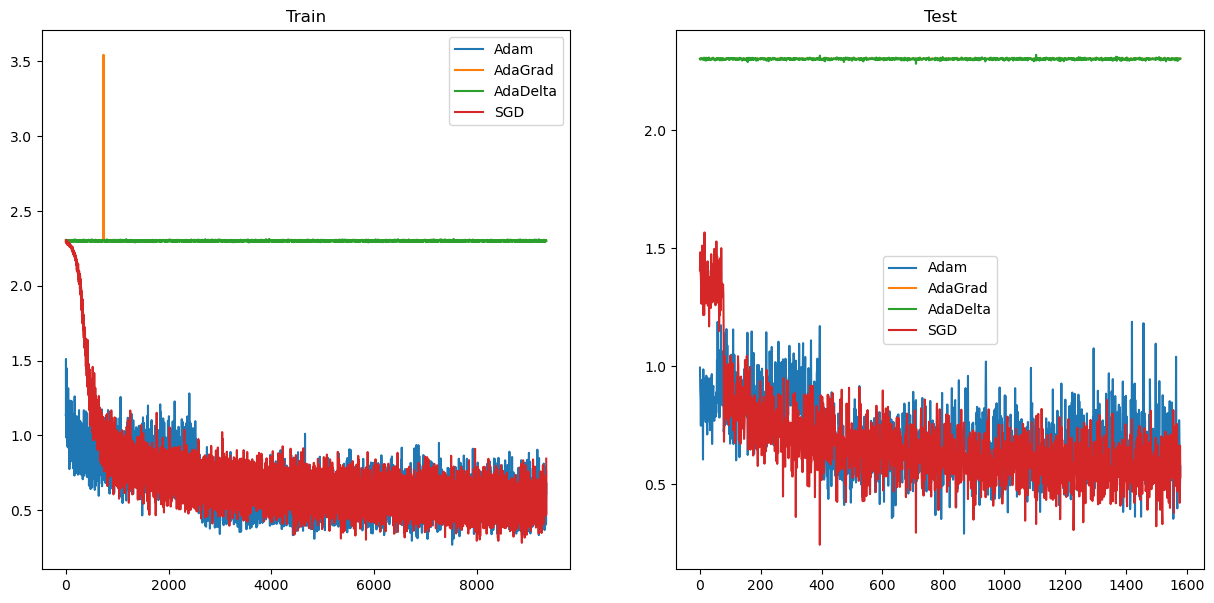

In [44]:
plt.figure(figsize=(15,7))
plt.subplot(121, title='Train')
for name in ['Adam', 'AdaGrad', 'AdaDelta', 'SGD']:
    plt.plot(losses[name][0][25:], label=name)
plt.legend();
plt.subplot(122, title='Test')
for name in ['Adam', 'AdaGrad', 'AdaDelta', 'SGD']:
    plt.plot(losses[name][1], label=name)
plt.legend();

Чтобы было удобнее анализоровать график ошибок, пройдёмся по нему скользящим окном

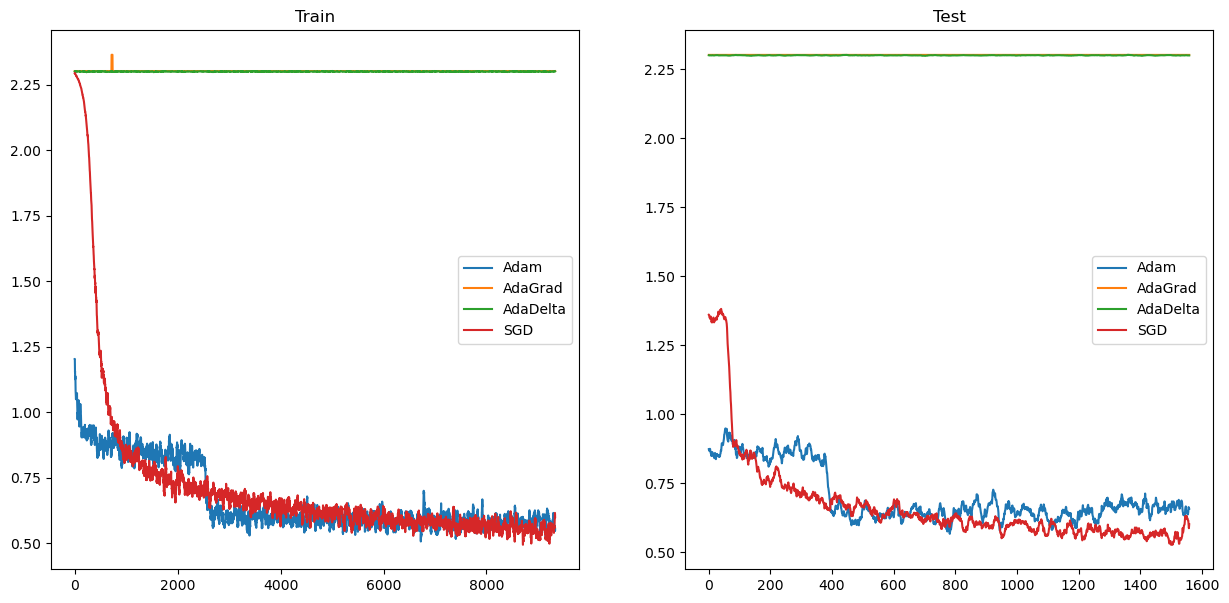

In [45]:
w=20
plt.figure(figsize=(15,7))
plt.subplot(121, title='Train')
for name in ['Adam', 'AdaGrad', 'AdaDelta', 'SGD']:
    plt.plot([np.mean(losses[name][0][i:i+w]) for i in range(25, len(losses[name][0])-w)], label=name)
plt.legend();
plt.subplot(122, title='Test')
for name in ['Adam', 'AdaGrad', 'AdaDelta', 'SGD']:
    plt.plot([np.mean(losses[name][1][i:i+w]) for i in range(len(losses[name][1])-w)], label=name)
plt.legend();

В итоге, методы Adam и SGD показывают наилучшие результаты. Скорость сходимости у SGD более постоянная, и Adam за счёт скачков иногда показывает лучшее качество. К концу обучения лучшее качество из всех методов показал SGD.

Методы AdaGrad и AdaDelta со значениями гиперпараметров, взятыми из задания 1.2 перестали сходиться ещё в начале обучения, и оба показали одинаково плохое качество.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: